In [1]:
# Data Analysis
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats

# Data Visualization
from matplotlib import pyplot as plt

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [3]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [4]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Mercury data

In [5]:
df_mercury = pd.read_csv('./MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'], sep="              ")

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1081735730.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_mercury = pd.read_csv('./MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'], sep="              ")


Log file has 80854 entries and 5 columns.


,Timestamp,Node,Subsystem,Message,Type
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
1,1167637660,tg-c645,PRO,Device Error Info Section,computation
2,1167637660,tg-c645,PRO,Error Map: x,computation
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
4,1167637720,tg-c645,PRO,Device Error Info Section,computation


# System (Mercury)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



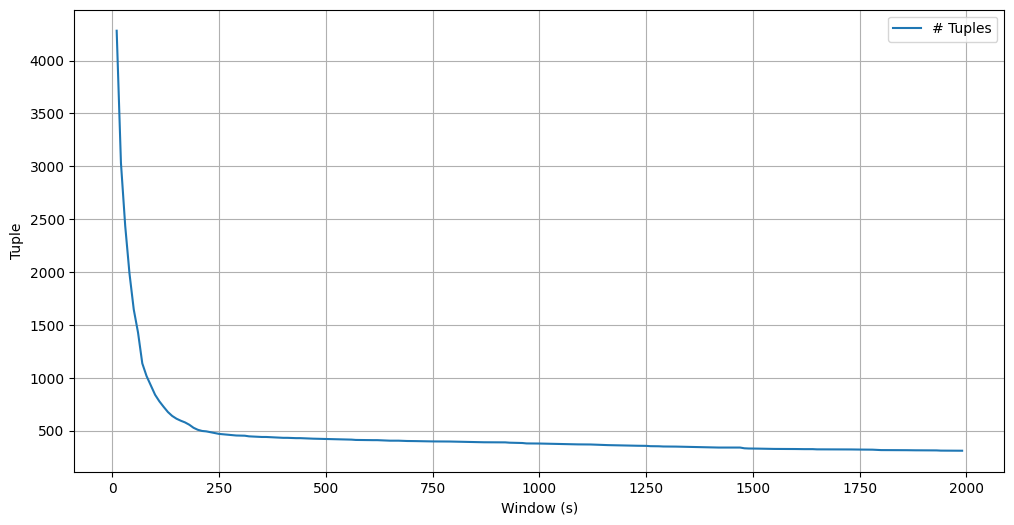

In [6]:
c_wins = np.delete(np.arange(0,2000,10), 0)

filepath = './data/system/Mercury-Sensitivity.csv'

df_mercury_sensitivity = sensitivity_analysis(df_mercury, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuple')
plt.legend()
plt.grid()
plt.savefig("./img/system/Mercury_System_Sensitivity.svg", format = "svg")
plt.show()

#### Tupling

In [7]:
window = 200

filepath = './data/system/Mercury-Data.csv'

df_mercury = tupling(df_mercury, window, filepath)
df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_mercury.tail()

File already exists!



,Timestamp,Node,Subsystem,Message,Type,Tuple
80849,1174943008,tg-c196,I-O,hda: packet command error: error=x,computation,506
80850,1174943068,tg-c128,I-O,hda: packet command error: error=x,computation,506
80851,1174943068,tg-c128,I-O,hda: packet command error: error=x,computation,506
80852,1174943925,tg-c196,NET,connection down,computation,507
80853,1174943943,tg-c196,I-O,hda: packet command error: error=x,computation,507


In [8]:
num_tuple = df_mercury.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  508


In [9]:
df_sys_stat = statistics(df_mercury)
df_sys_stat.head()

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)


,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,6,1167637660,1167637720,60,0.1,NaN
1,3,1167655228,1167655229,1,3,17508
2,61,1167657137,1167657302,165,0.369697,1908
3,14,1167657550,1167657550,0,inf,248
4,2,1167657941,1167657941,0,inf,391


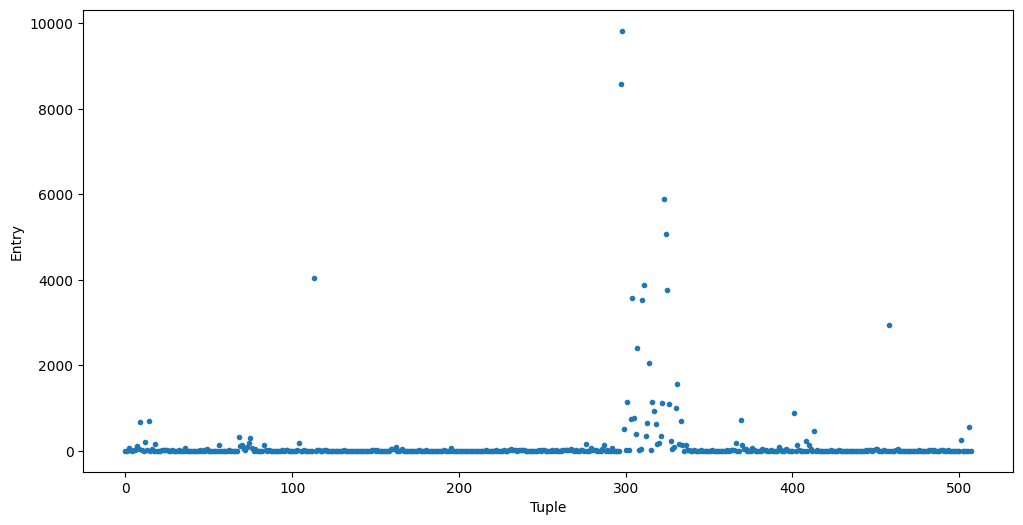

In [10]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuple')
plt.ylabel('Entry')

plt.savefig("./img/system/Mercury_System_Scatter_Tuple_Entry.svg", format = "svg")
plt.show()

#### Bottleneck

In [11]:
start_tup = 297
end_tup = 330

df_bottleneck = df_mercury.loc[(df_mercury['Tuple']>=start_tup) & (df_mercury['Tuple']<=end_tup)]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Type,Tuple
10162,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,297
10163,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,297
10164,1171321113,tg-c401,DEV,"Component Info: Vendor Id =x x, Device Id =x x...",computation,297
10165,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,297
10166,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,297


In [17]:
df_bottleneck.groupby(by='Node').Timestamp.count().sort_values(ascending=False)

Node
tg-c401      60105
tg-s176         13
tg-c027          9
tg-c106          7
tg-c407          4
tg-master        4
tg-c735          3
tg-c128          2
tg-s044          2
tg-c685          1
tg-c894          1
Name: Timestamp, dtype: int64

In [18]:
df_bottleneck = df_bottleneck.loc[(df_bottleneck['Node']=='tg-c401')]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Type,Tuple
10162,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,297
10163,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,297
10164,1171321113,tg-c401,DEV,"Component Info: Vendor Id =x x, Device Id =x x...",computation,297
10165,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,297
10166,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,297


### Truncation analysis

In [19]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 280.6


In [20]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
3,14,1167657550,1167657550,0,inf,248
5,11,1167658201,1167658201,0,inf,260
6,16,1167658404,1167658456,52,0.307692,203
8,42,1167659488,1167659772,284,0.147887,211
9,680,1167660001,1167665307,5306,0.128157,229


In [21]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 51
Estimate percentage of truncations: 10.039370078740157


In [22]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()
df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
505   tg-master          4          4        4     4
506   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
507   tg-c196            2          2        2     2

In [23]:
df_group = df_group.reset_index(level = 1)

In [24]:
collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1
        tup_index = str(tup)
        filepath = './data/system/tuple_collision/tuple-' + tup_index + '.csv'
        (df_mercury.loc[df_mercury['Tuple'] == tup]).to_csv(filepath)
        df_entry_count = (df_mercury.loc[df_mercury['Tuple'] == tup]).groupby(by='Tuple').count()['Timestamp']
        

In [25]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 47
Estimate percentage of collisions:  9.251968503937007


## Data Analysis

### Empirical reliability

In [14]:
data = df_sys_stat['Interarrival'].dropna().to_numpy()

ecdf = ECDF(data)

tempi_int = pd.DataFrame(df_sys_stat['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
np.savetxt(r'./script_matlab/system/tempi_int.txt', tempi_int, fmt='%d')

# Subsystems

In [15]:
subsystems = df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).drop('OTH')

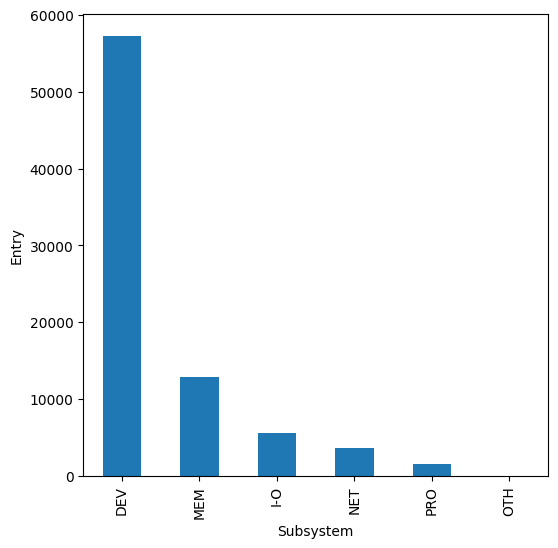

In [16]:
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar(figsize=(6,6))
plt.ylabel('Entry')
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [17]:
c_wins = np.delete(np.arange(0,500,1), 0)

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/components/Mercury-' + subsys + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



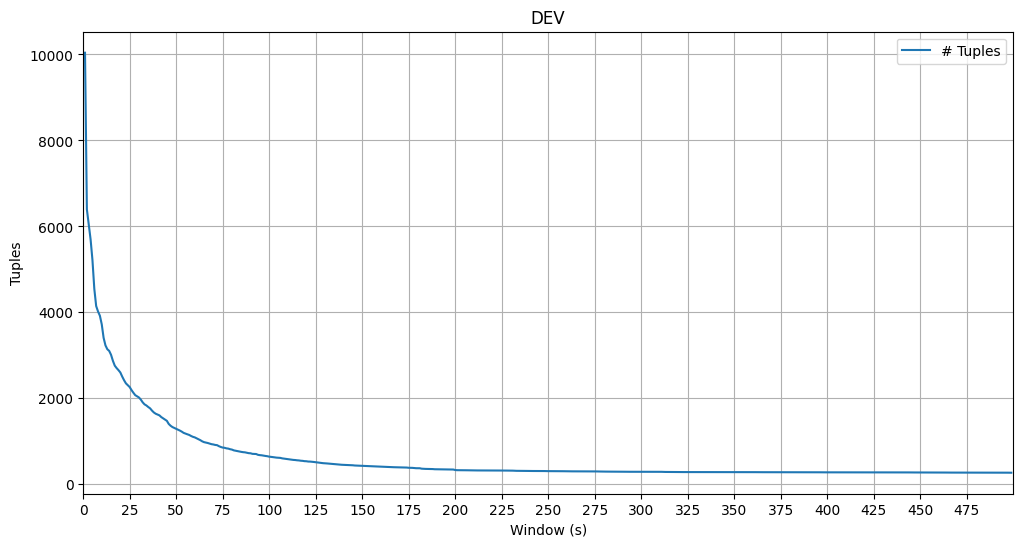

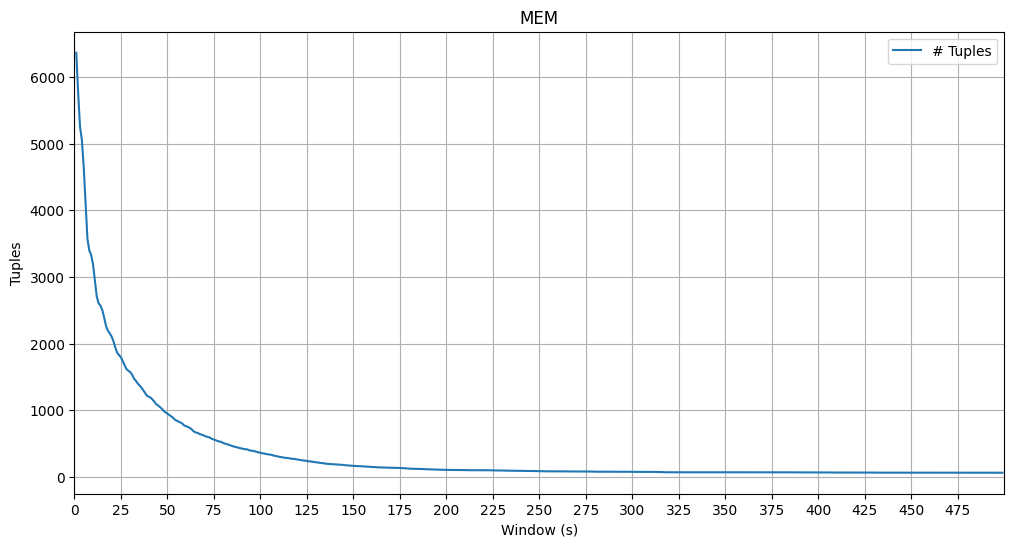

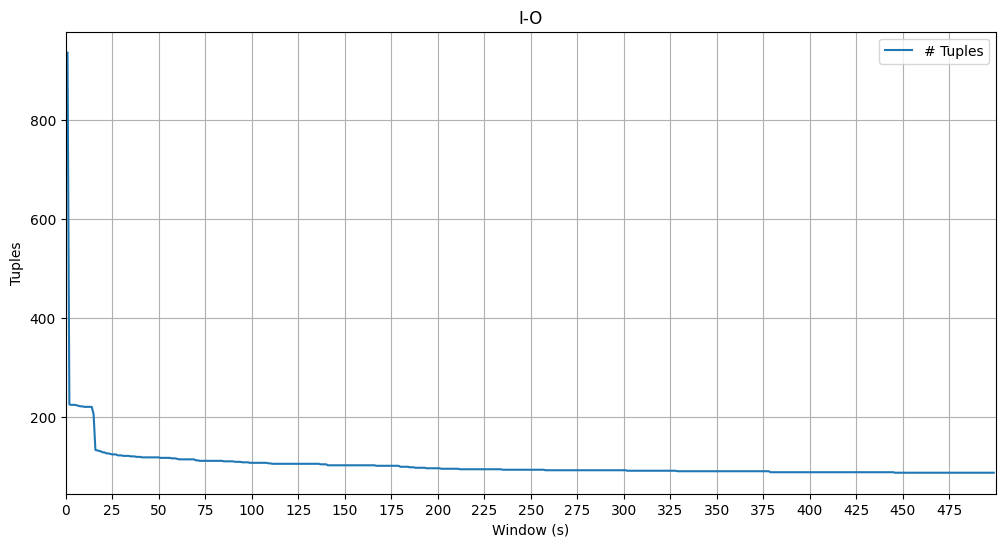

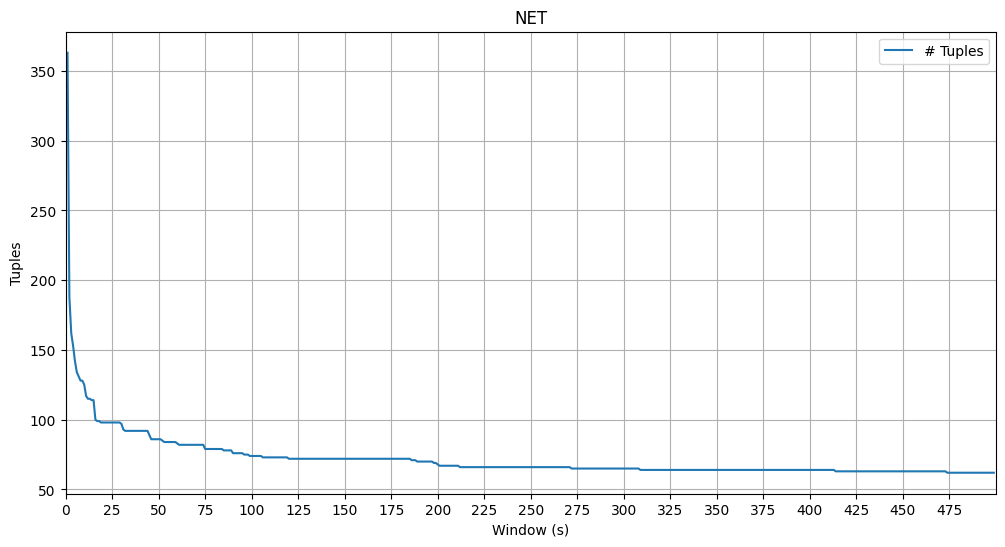

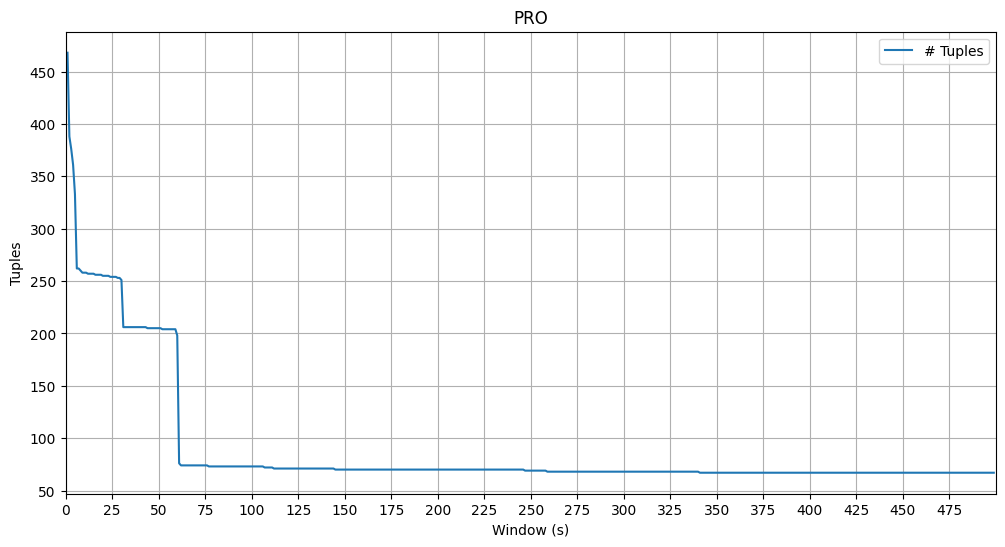

In [18]:
for subsys in subsystems.index:
    filepath = './data/components/Mercury-' + subsys + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(subsys)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/components/Mercury_Subsystem_Sensitivity_" + subsys + ".svg", format = "svg")
    plt.show()

In [19]:
win_dict = {'DEV' : 200,
            'MEM' : 200,
            'I-O' : 100,
            'NET' : 100,
            'PRO' : 100}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'DEV': 200, 'MEM': 200, 'I-O': 100, 'NET': 100, 'PRO': 100}


#### Tupling

In [20]:
dict_df_cat_stat = {}
dict_cat_num_tup = {}

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/components/Mercury-' + subsys + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[subsys], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_cat_num_tup[subsys] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_cat_stat[subsys] = df_stat

print('Number of tuples:', dict_cat_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'DEV': 334, 'MEM': 105, 'I-O': 107, 'NET': 74, 'PRO': 73}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

## Data Analysis

### Empirical reliability

In [21]:
for subsys in subsystems.index:
    
    ecdf = ECDF(dict_df_cat_stat[subsys]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_cat_stat[subsys]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./script_matlab/components/tempi_int'+subsys+'.txt', tempi_int, fmt='%d')

subsystems.to_excel('./script_matlab/components/names.xls')

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/3422710388.py:8: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  subsystems.to_excel('./script_matlab/components/names.xls')


# Types

In [22]:
types = df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False)

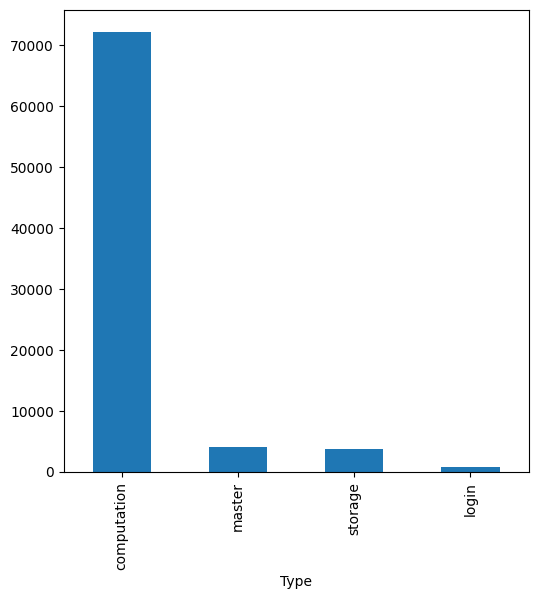

In [23]:
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar(figsize=(6,6))
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [24]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/types/Mercury-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!



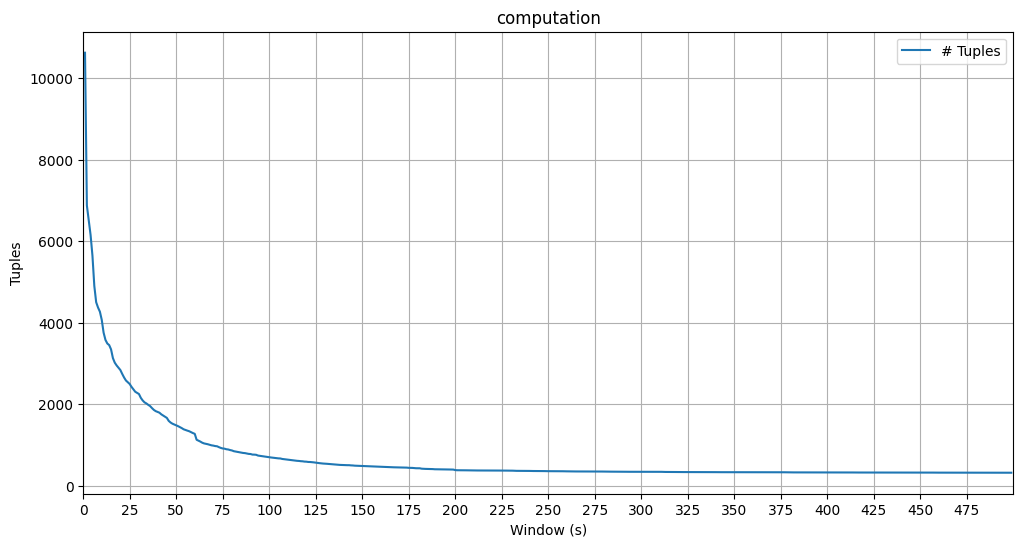

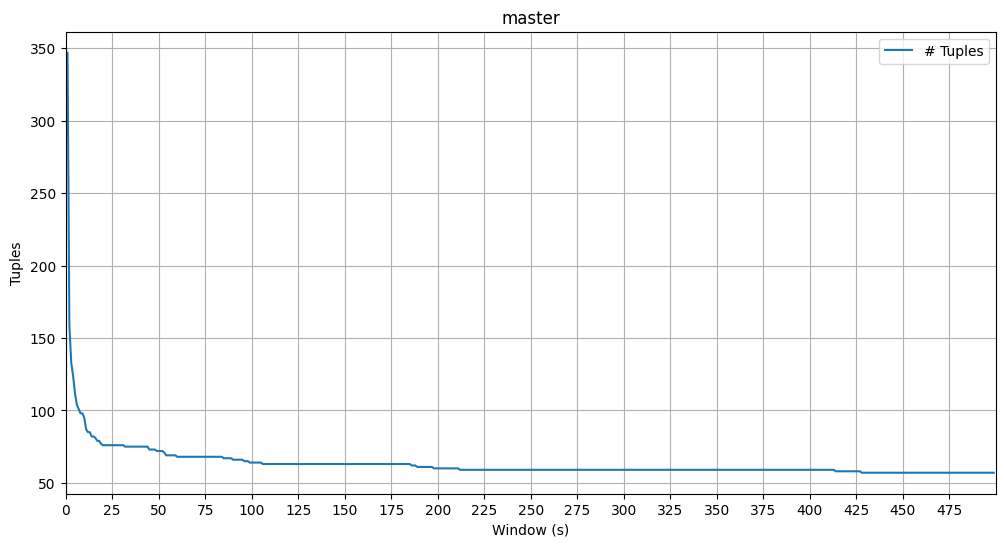

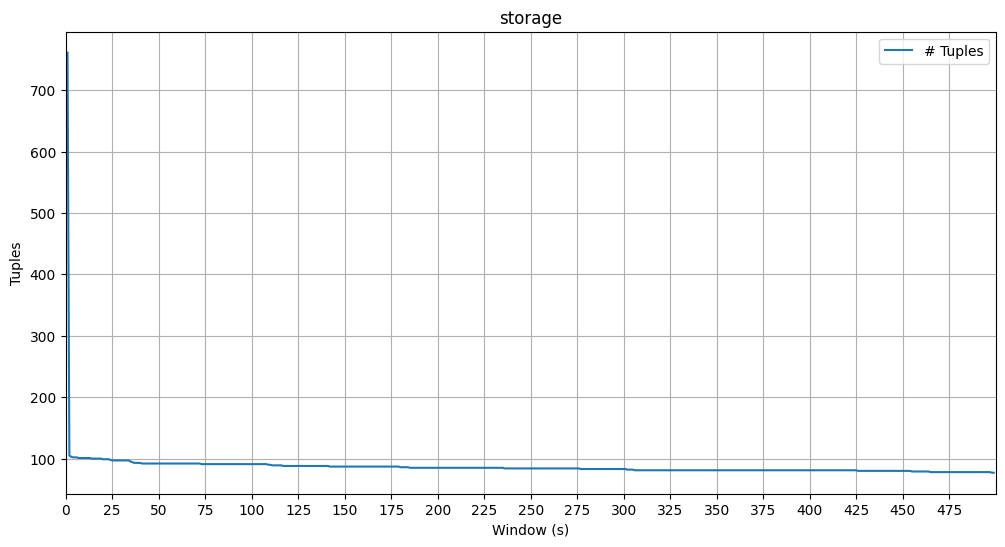

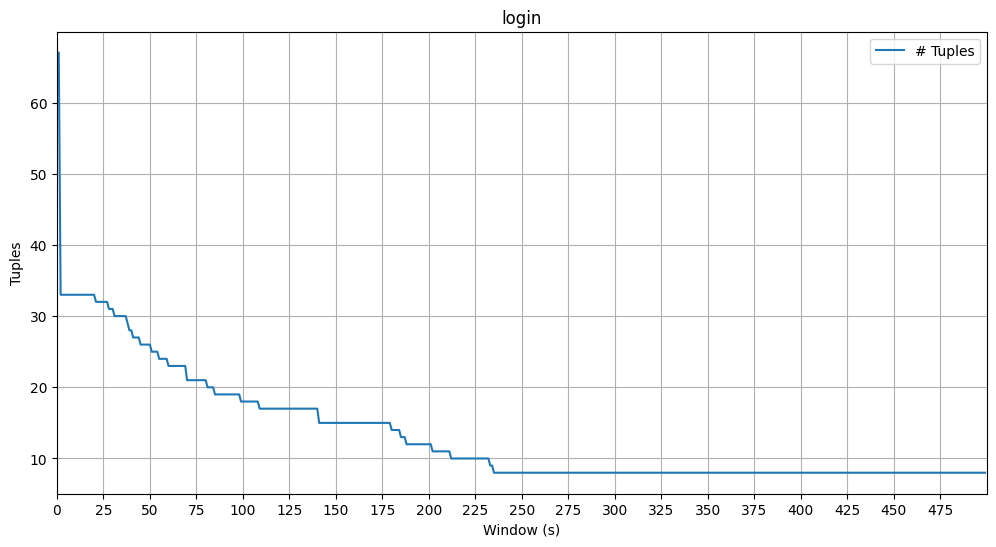

In [25]:
for t in types.index:
    filepath = './data/types/Mercury-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/type/Mercury_Type_Sensitivity_" + t + ".svg", format = "svg")

In [26]:
win_dict = {'computation' : 200,
            'master' : 150,
            'storage' : 100,
            'login' : 300}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'computation': 200, 'master': 150, 'storage': 100, 'login': 300}


#### Tupling

In [27]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/types/Mercury-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'computation': 382, 'master': 63, 'storage': 91, 'login': 8}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

## Data Analysis

### Empirical reliability

In [28]:
for t in types.index:
    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_type_stat[t]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./script_matlab/types/tempi_int'+t+'.txt', tempi_int, fmt='%d')

types.to_excel('./script_matlab/types/names.xls')


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/308132355.py:7: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  types.to_excel('./script_matlab/types/names.xls')


# Top nodes

In [29]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


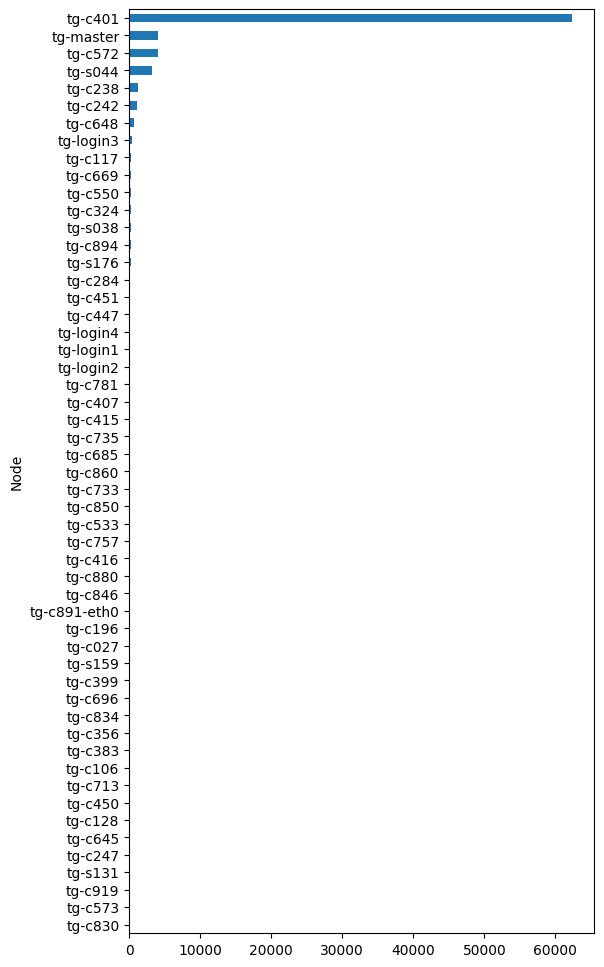

In [30]:
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh(figsize=(6,12))
plt.show()

In [31]:
top_5 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending = False)[0:5]
top_5

Node
tg-c401      62340
tg-master     4098
tg-c572       4030
tg-s044       3224
tg-c238       1273
Name: Timestamp, dtype: int64

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [32]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/nodes/Mercury-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



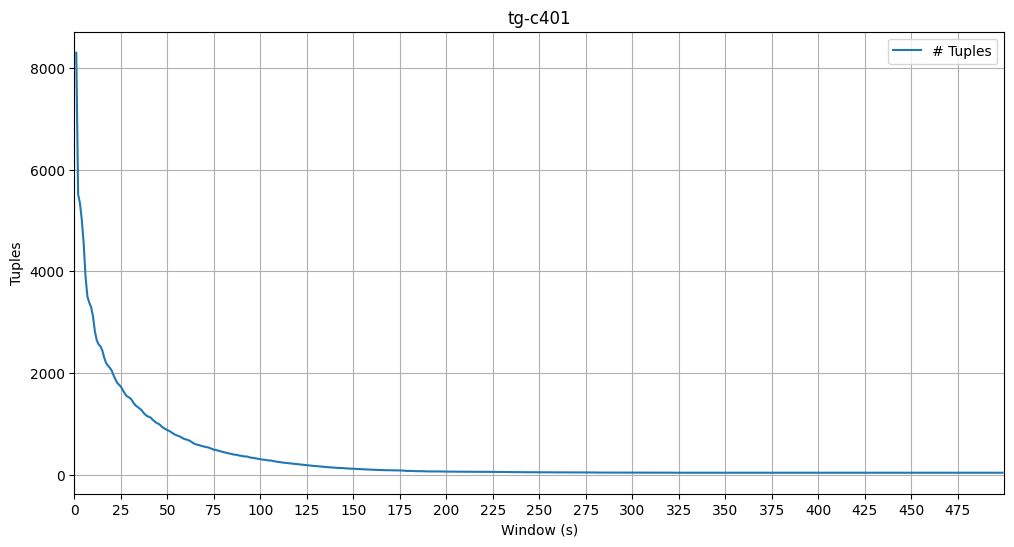

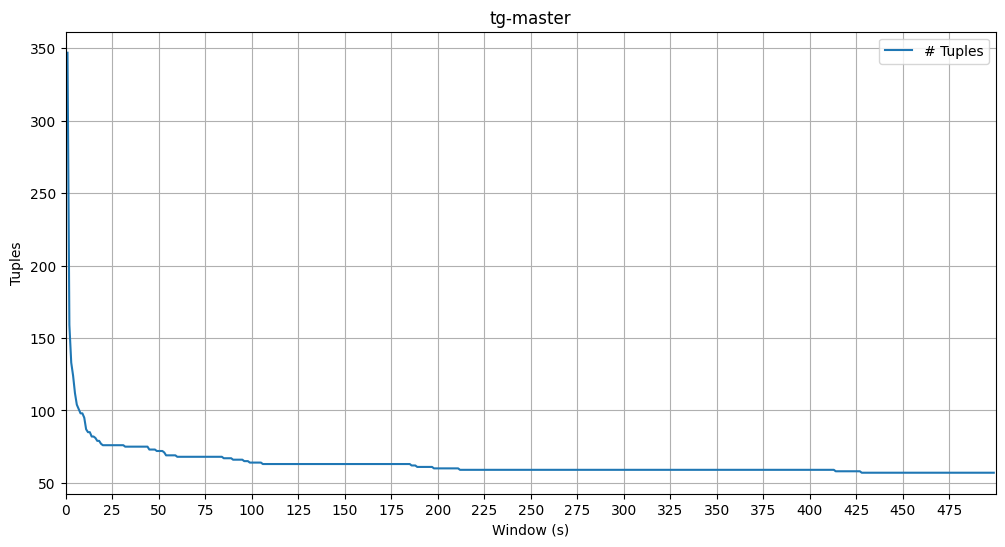

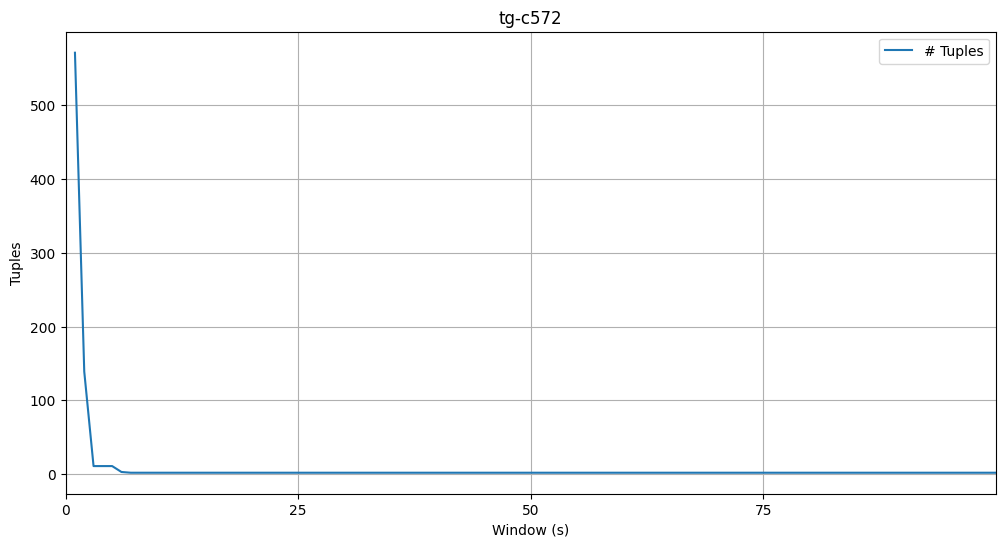

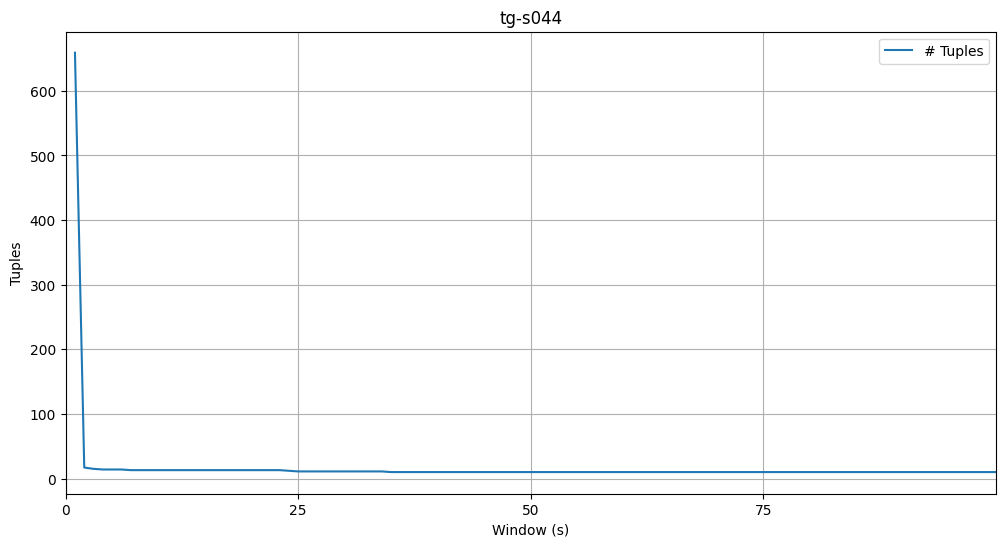

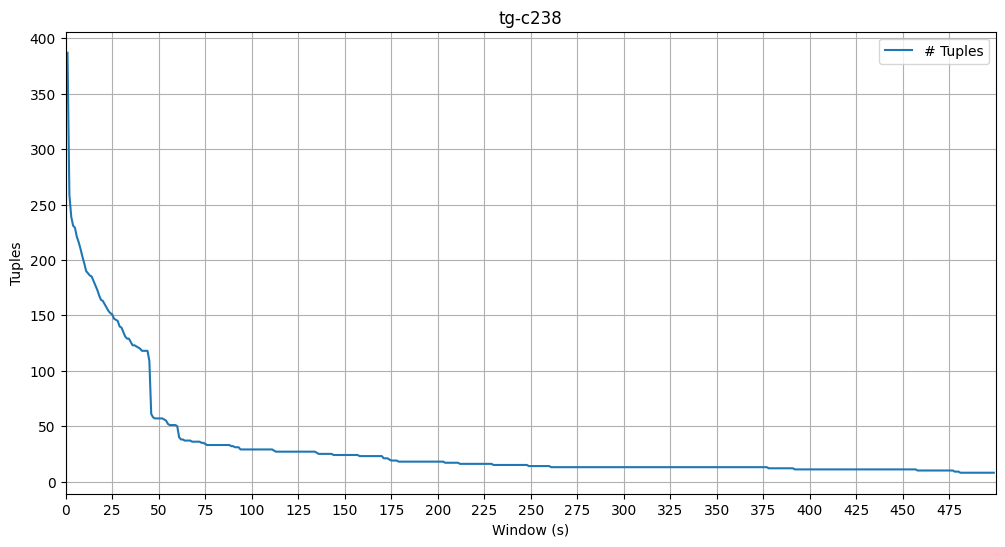

In [33]:
x_dict = {'tg-c401' : 500,
          'tg-master' : 500,
          'tg-c572' : 100,
          'tg-s044' : 100,
          'tg-c238' : 500}

for node in top_5.index:
    filepath = './data/nodes/Mercury-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,x_dict[node])
    plt.xticks(np.arange(0, x_dict[node], step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/nodes/Mercury_Top_Sensitivity_" + node + ".svg", format = "svg")

In [34]:
win_dict = {'tg-c401' : 200,
            'tg-master' : 200,
            'tg-c572' : 20,
            'tg-s044' : 30,
            'tg-c238' : 200}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'tg-c401': 200, 'tg-master': 200, 'tg-c572': 20, 'tg-s044': 30, 'tg-c238': 200}


#### Tupling

In [35]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/nodes/Mercury-' + node + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'tg-c401': 59, 'tg-master': 60, 'tg-c572': 2, 'tg-s044': 11, 'tg-c238': 18}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

## Data Analysis

### Empirical reliability

In [44]:
top_2 = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_2:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_node_stat[node]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./script_matlab/nodes/tempi_int'+node+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(top_2)
df.to_excel('./script_matlab/nodes/names.xls')

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_994/3147490202.py:11: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./script_matlab/nodes/names.xls')


# Bottleneck

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

Creating file ./data/nodes/Mercury-bottleneck-Sensitivity.csv this may take a while...



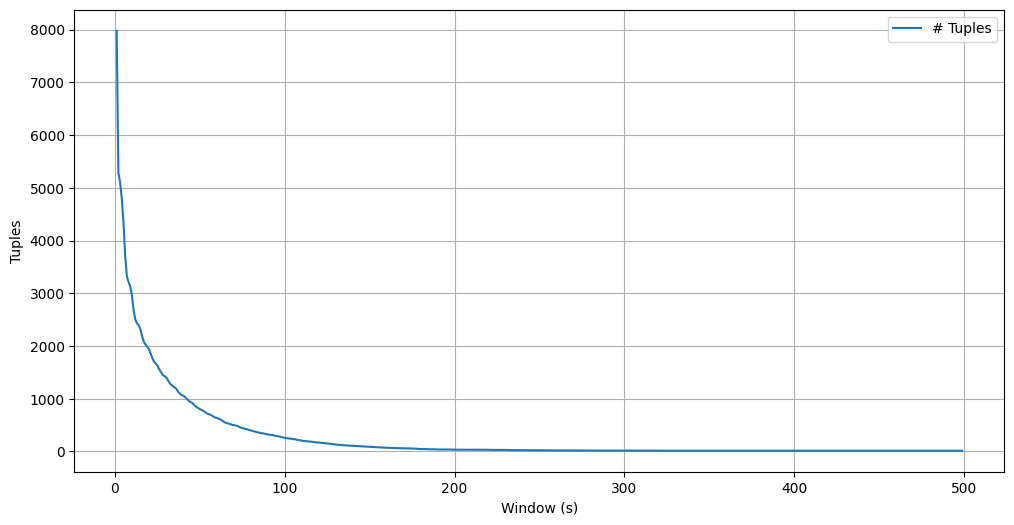

In [54]:
c_wins = np.delete(np.arange(0,500,1), 0)

filepath = './data/nodes/Mercury-bottleneck-Sensitivity.csv'

df_bottleneck.reset_index(drop = True, inplace = True)
df_bottleneck_sensitivity = sensitivity_analysis(df_bottleneck, c_wins, filepath)

plt.figure(figsize=(12,6))

plt.plot(df_bottleneck_sensitivity['Window'], df_bottleneck_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("./img/nodes/Mercury_Bottleneck_Sensitivity.svg", format = "svg")

#### Tupling

In [55]:
window = 200
filepath = './data/nodes/Mercury-bottleneck-Data.csv'

df_bottleneck = tupling(df_bottleneck, window, filepath)
df_bottleneck = df_bottleneck.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bottleneck.head()

Creating file ./data/nodes/Mercury-bottleneck-Data.csv this may take a while...



,Timestamp,Node,Subsystem,Message,Type,Tuple
0,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,0
1,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,0
2,1171321113,tg-c401,DEV,"Component Info: Vendor Id =x x, Device Id =x x...",computation,0
3,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,0
4,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,0


In [56]:
num_tuple = df_bottleneck.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  34


In [57]:
df_bottleneck_stat = statistics(df_bottleneck)
df_bottleneck_stat.head()

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_18196/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)


,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,8569,1171321113,1171337216,16103,0.532137,NaN
1,9822,1171337536,1171356961,19425,0.505637,320
2,503,1171357195,1171358506,1311,0.383677,234
3,11,1171358737,1171358737,0,inf,231
4,1133,1171359013,1171360978,1965,0.57659,276


## Data Analysis 

### Empirical time to failure distribution

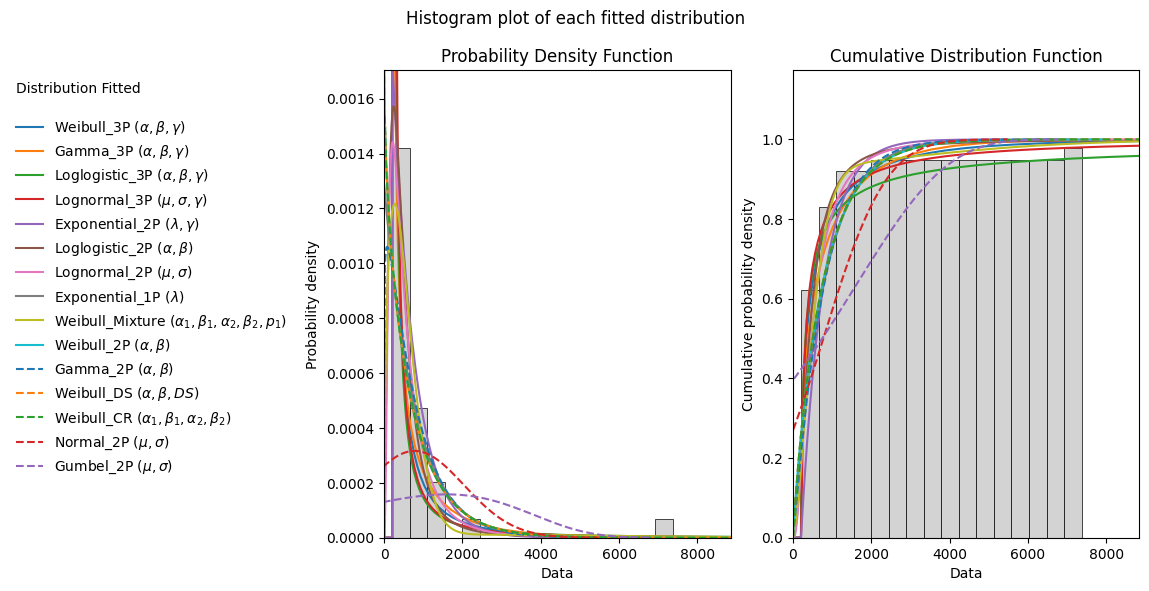

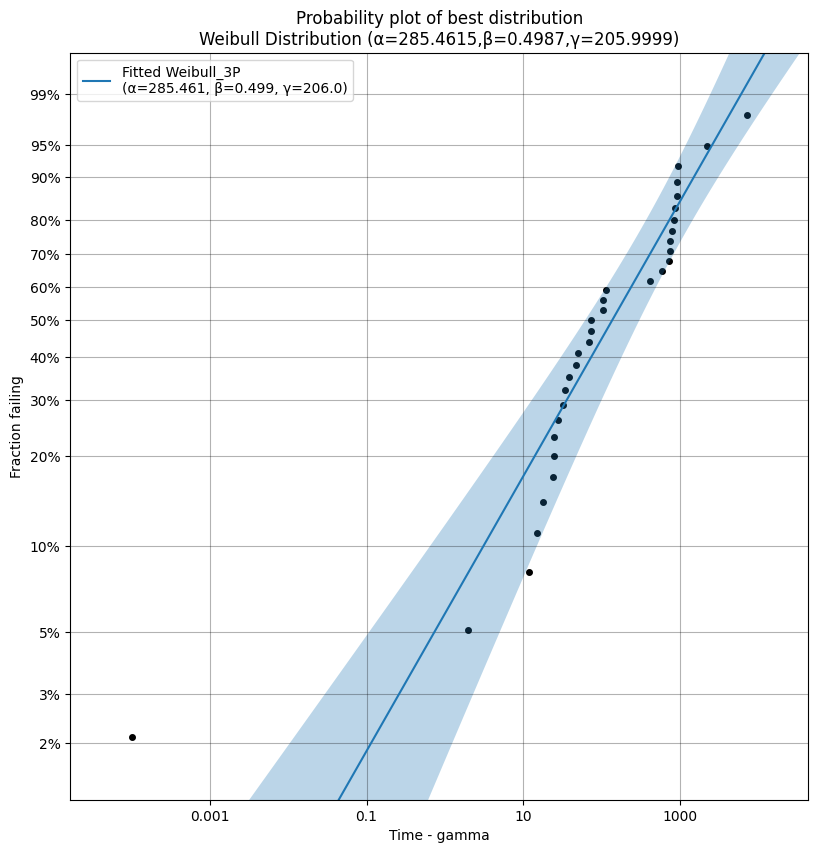

The best fitting distribution was Weibull_3P which had parameters [285.4614654    0.49872288 205.9999    ]


In [58]:
data = df_bottleneck_stat['Interarrival'].dropna().to_numpy()
   
results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

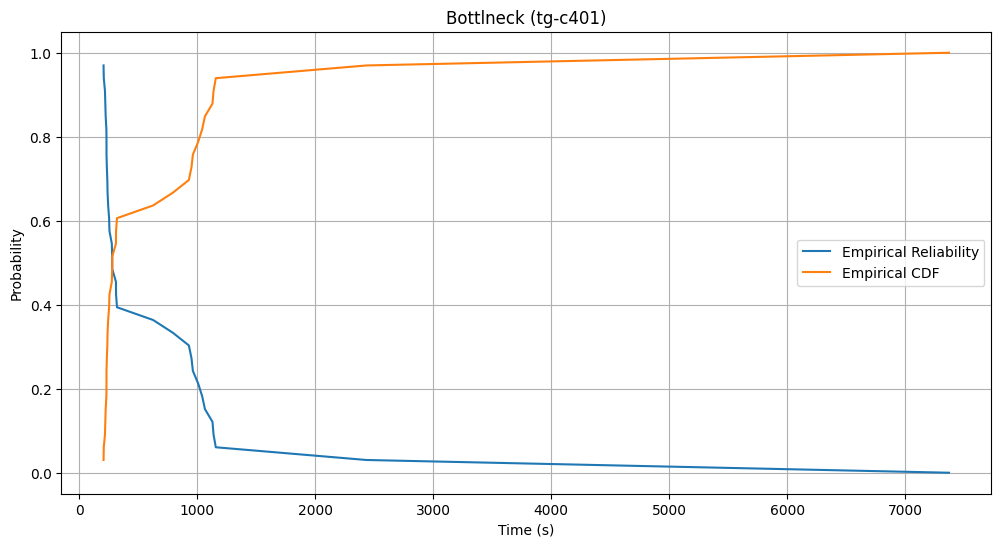

In [59]:
ecdf = ECDF(df_bottleneck_stat['Interarrival'].dropna())

plt.figure(figsize=(12,6))
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
plt.title('Bottlneck (tg-c401)')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./img/nodes/Mercury_Bottleneck_Emp_Reliability.svg", format = "svg")

### General Analysis

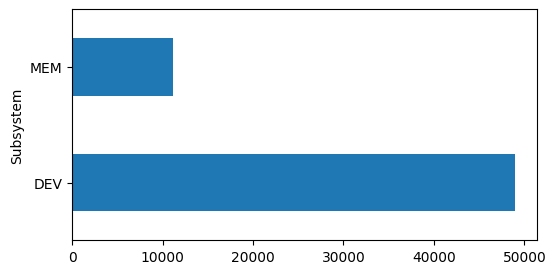

In [60]:
df_bottleneck.groupby(by='Subsystem').Timestamp.count().plot.barh(figsize=(6,3))

plt.savefig("./img/nodes/Mercury_Bottleneck_Bar_Subsystem.svg", format = "svg")
plt.show()

In [61]:
df_bottleneck_msg = df_bottleneck.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

print(df_bottleneck_msg.to_latex())
df_bottleneck_msg

\begin{tabular}{llr}
\toprule
    &                                                                                                          &  Timestamp \\
Subsystem & Message &            \\
\midrule
DEV & + Platform Specific Error Detail: &       5278 \\
    & +BEGIN HARDWARE ERROR STATE AT CPE &       5819 \\
    & +END HARDWARE ERROR STATE AT CPE &       3700 \\
    & +Platform PCI Component Error Info Section &       6567 \\
    & +Platform Specific Error Info Section &       5233 \\
    & Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x &      22352 \\
MEM & + Mem Error Detail: &          4 \\
    & Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x, &      11152 \\
\bottomrule
\end{tabular}



/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_18196/1887006794.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_bottleneck_msg.to_latex())


Timestamp
Subsystem Message                                                      
DEV       + Platform Specific Error Detail:                        5278
          +BEGIN HARDWARE ERROR STATE AT CPE                       5819
          +END HARDWARE ERROR STATE AT CPE                         3700
          +Platform PCI Component Error Info Section               6567
          +Platform Specific Error Info Section                    5233
          Component Info: Vendor Id =x x, Device Id =x x,...      22352
MEM       + Mem Error Detail:                                         4
          Physical Address x, Address Mask: x, Node: x, C...      11152